In [32]:
import requests

API_KEY = "YOUR_API_KEY"
symbol = "GOOGL"

url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={API_KEY}"

response = requests.get(url)
data = response.json()

# Convert to dataframe
stock_data = pd.DataFrame.from_dict(data["Time Series (Daily)"], orient="index")
stock_data = stock_data.astype(float)

stock_data.head()


,1. open,2. high,3. low,4. close,5. volume
2026-02-17,300.040,304.435,296.25,302.02,39247556.0
2026-02-13,307.725,308.630,303.71,305.72,38499701.0
2026-02-12,312.090,316.240,307.20,309.00,47761288.0
2026-02-11,318.970,321.060,309.66,310.96,45406405.0
2026-02-10,320.970,321.670,314.61,318.58,39170012.0


In [ ]:
import websocket
import json

def on_message(ws, message):
    print("Live Price Update:", message)

def on_error(ws, error):
    print(error)

def on_close(ws):
    print("Connection closed")

def on_open(ws):
    print("Connected to live stock feed")

ws = websocket.WebSocketApp(
    "wss://streamer.finance.yahoo.com",
    on_open=on_open,
    on_message=on_message,
    on_error=on_error,
    on_close=on_close
)

ws.run_forever()


Connected to live stock feed


In [13]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("microsoft_stock_prices_2016_2026_refined.csv")
df.head()

,Date,Close,High,Low,Open,Volume
0,2016-02-03,45.671837,46.748837,44.883786,46.626252,57559800
1,2016-02-04,45.531754,46.240999,44.980118,45.619313,46987100
2,2016-02-05,43.920628,45.531751,43.395263,45.479213,62009000
3,2016-02-08,43.263927,43.404025,42.195681,43.386512,59290500
4,2016-02-09,43.150074,43.990662,42.615951,42.922417,46740500


In [3]:
df["Date"] = pd.to_datetime(df["Date"])
df.sort_values("Date", inplace=True)

In [4]:
# If next day close > today close → 1 Else → 0
df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
df.dropna(inplace=True)

In [5]:
df["Price_Range"] = df["High"] - df["Low"]
df["Daily_Return"] = df["Close"] - df["Open"]
df["Volume_Change"] = df["Volume"].pct_change()

df.dropna(inplace=True)


In [6]:
X = df.drop(["Date","Target"], axis=1)
y = df["Target"]

In [8]:
split = int(len(df) * 0.8)

X_train = X[:split]
X_test = X[split:]

y_train = y[:split]
y_test = y[split:]


In [9]:
!pip install xgboost
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        random_state=42
    ))
])


In [10]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [11]:
y_pred = pipeline.predict(X_test)

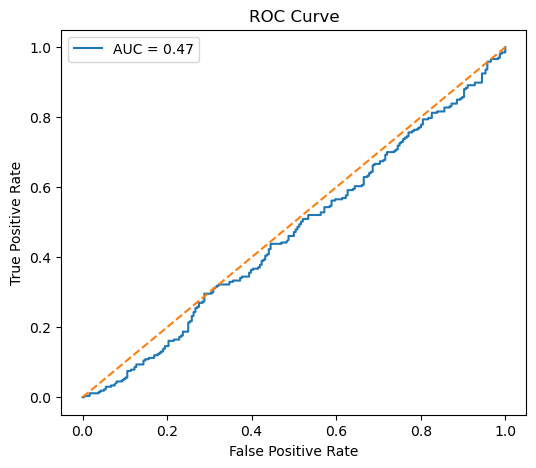

In [14]:
from sklearn.metrics import roc_curve, auc

y_prob = pipeline.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


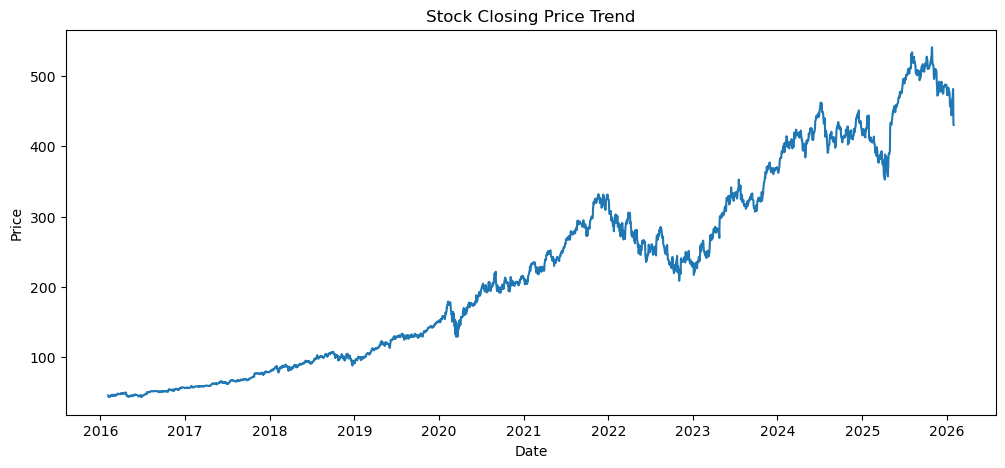

In [15]:
plt.figure(figsize=(12,5))
plt.plot(df["Date"], df["Close"])
plt.title("Stock Closing Price Trend")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


In [16]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))


[[ 70 166]
 [ 88 179]]
              precision    recall  f1-score   support

           0       0.44      0.30      0.36       236
           1       0.52      0.67      0.58       267

    accuracy                           0.50       503
   macro avg       0.48      0.48      0.47       503
weighted avg       0.48      0.50      0.48       503



In [17]:
from sklearn.metrics import accuracy_score

y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.49502982107355864


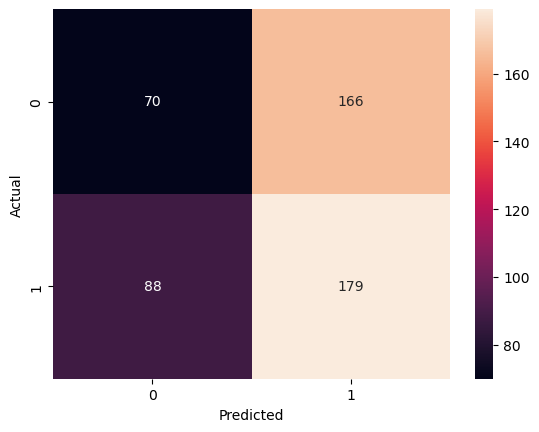

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [19]:

new_data = pd.DataFrame([[
    45.6, 46.7, 44.8, 46.6, 57559800,
    1.9, -0.9, 0.02
]], columns=X.columns)

prediction = pipeline.predict(new_data)
print("UP" if prediction[0]==1 else "DOWN")

DOWN


In [20]:
df = df.copy()

# Price change
df["Return"] = df["Close"].pct_change()

# Moving averages
df["MA_5"] = df["Close"].rolling(5).mean()
df["MA_10"] = df["Close"].rolling(10).mean()

# Volatility
df["Volatility"] = df["Return"].rolling(5).std()

# Price momentum
df["Momentum"] = df["Close"] - df["Close"].shift(5)


In [21]:
df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)

In [23]:
backtest = X_test.copy()
backtest['Actual'] = y_test.values
backtest['Prediction'] = y_pred


backtest['Close'] = df.loc[backtest.index, 'Close']
backtest['Market_Return'] = backtest['Close'].pct_change()

backtest['Strategy_Return'] = backtest['Market_Return'] * backtest['Prediction']

# Cumulative returns
backtest['Market_Cum'] = (1 + backtest['Market_Return']).cumprod()
backtest['Strategy_Cum'] = (1 + backtest['Strategy_Return']).cumprod()

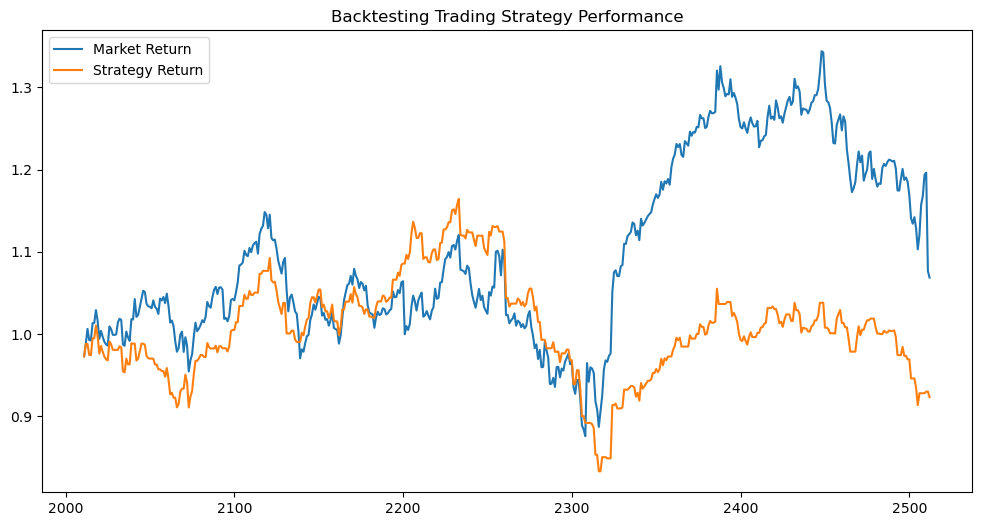

Final Strategy Return: 0.9233701230366724


In [25]:
plt.figure(figsize=(12,6))
plt.plot(backtest['Market_Cum'], label='Market Return')
plt.plot(backtest['Strategy_Cum'], label='Strategy Return')
plt.legend()
plt.title("Backtesting Trading Strategy Performance")
plt.show()

print("Final Strategy Return:", backtest['Strategy_Cum'].iloc[-1])

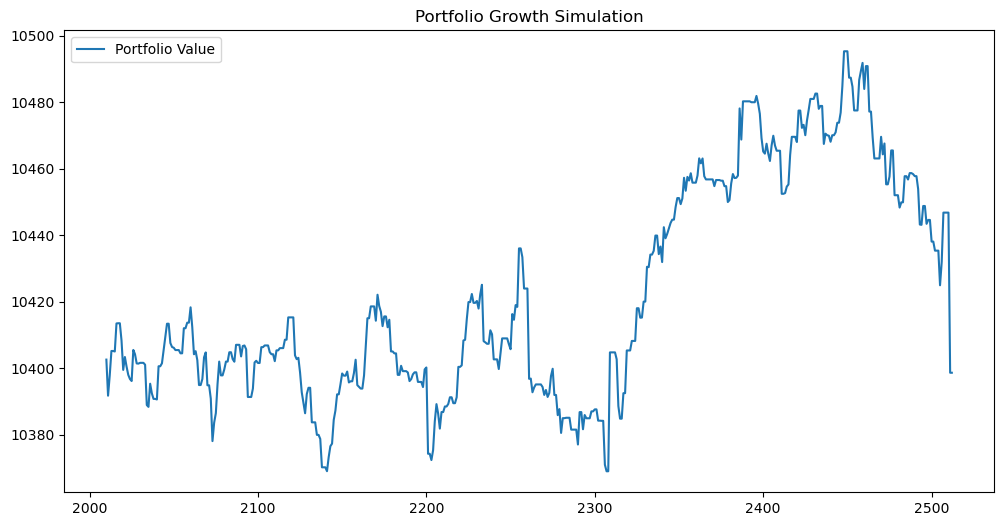

In [27]:
# Portfolio Simulation

initial_capital = 10000
backtest['Position'] = backtest['Prediction']

backtest['Holdings'] = backtest['Position'] * backtest['Close']
backtest['Cash'] = initial_capital - (backtest['Position'].diff().fillna(0) * backtest['Close']).cumsum()
backtest['Total'] = backtest['Cash'] + backtest['Holdings']

plt.figure(figsize=(12,6))
plt.plot(backtest['Total'], label='Portfolio Value')
plt.legend()
plt.title("Portfolio Growth Simulation")
plt.show()


In [29]:
backtest = df.loc[X_test.index].copy()

backtest['Prediction'] = y_pred

backtest['Market_Return'] = backtest['Close'].pct_change()

backtest['Strategy_Return'] = backtest['Market_Return'] * backtest['Prediction']


backtest['Market_Total'] = (1 + backtest['Market_Return']).cumprod()
backtest['Strategy_Total'] = (1 + backtest['Strategy_Return']).cumprod()

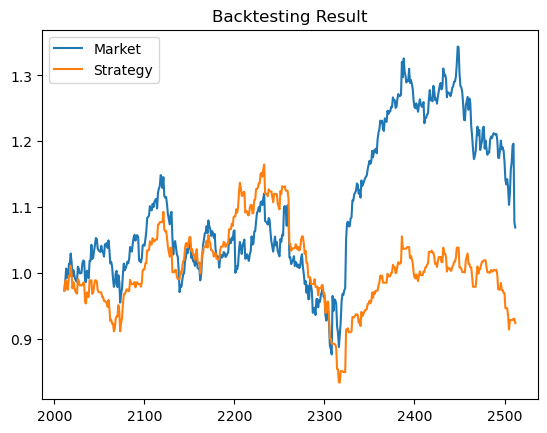

Strategy Profit: 0.9233701230366724


In [31]:

plt.plot(backtest['Market_Total'], label="Market")
plt.plot(backtest['Strategy_Total'], label="Strategy")
plt.legend()
plt.title("Backtesting Result")
plt.show()

# Final profit
print("Strategy Profit:", backtest['Strategy_Total'].iloc[-1])
